# Exponential Mechanism

In this notebook we introduce the exponential mechanism as in [The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf). We consider three different examples that show how general the mechanism is.

Let $\mathcal X$ be the set of possible rows in a database so that we can represent a particular database by a histogram $x\in\mathbb N^{|\mathcal X|}$. Given an arbitrary response space $\mathcal R$ and a utility function

$$
u: \mathbb N^{|\mathcal X|}\times \mathcal R \rightarrow \mathbb R\,,
$$

we define the exponential mechanism as the collection of conditional probabilities given by

$$
P(r|x; u, \alpha) = \frac{e^{\alpha u(x,r) }}{\sum_{r'\in\mathcal R} e^{\alpha u(x,r')}}\,.
$$

In the case of uncountable $\mathcal R$, the sum in the denominator should be replaced with an integral and the expression above gives a probability density.

The exponential mechanism is an $\epsilon$-differentially private randomization algorithm with $\epsilon = 2\alpha\Delta u$ and

$$
\Delta u = \underset{r\in\mathcal R}{\rm max}\underset{||x-y||_1 \le 1}{\rm max} |u(x,r) - u(y,r)|\,.
$$

The utility function can be thought of as a generalization of a numeric query. In fact, one can show that this mechanism reduces to simpler ones for particular types of functions $u$. In order to illustrate this, we show how this works in two well-known examples.

#### Randomized response

Consider the case in which $\mathcal R = \{0, 1\}$ and $\mathcal X = \{\text{truly innocent}, \text{truly guilty}\}$ with a utility function such that 

$$
u(0, 0) = 0\qquad u(1, 0) = 0
$$
$$
u(0, 1) = \beta \qquad u(1, 1) = \gamma
$$

where $\beta, \gamma$ are real constants. The exponential mechanism reduces in this case to the simplest randomized response algorithm.


#### Laplace Mechanism

Consider the case in which $\mathcal R = \mathbb R$ and the ultility function is given by $u(x, r) = -|f(x) - r|$ with

$$
f: \mathbb N^{|\mathcal X|} \rightarrow \mathbb R\,.
$$

This is, by definition, the Laplace mechanism with $b = \alpha^{-1}$.

## Example: Pricing

The input dataset $x$ is a set of bids for the purchase of an abundant supply of a product. The problem is to identify the best price $r \in \mathcal{R} = [r_{min}, r_{max}]$ such as to maximize the revenue, without revealing the bids. In this case the revenue is our utility function $u$, defined as

$$
u(x, r) = r |S_r|
$$

with 

$$
S_r = \{i: x_i\ge r\}\,
$$

the set of people that are willing to buy at a price $r$.

In general, it is not possible to compute $\Delta u$ analytically and one must resort to statistical estimations of "typical" values of $\Delta u$. This is also the case when $\Delta u$ is not bounded. In our particular case, we can compute the sensitivity with respect to the utility, which is given by

$$
\Delta u = r_{max}.
$$

The complication in this case arises from the fact that the output price may not be directly perturbed. In  [Example 3.5 of The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf), they suppose there are four bidders: A, F, I, K, where A, F, I each bid 1.00&euro; and K bids 3.01&euro;, so $x = \{1, 1, 1, 3.01\}$.  Fixing the price to 3.01&euro; the revenue is $u =$ 3.01&euro;, at 3.00&euro; we have $u =$3.00&euro;, at 1.00&euro; we have $u =$4.00&euro;. However, if we fix the price at 3.02&euro; the revenue is zero! The revenue plot for this specific demand defined by $x$ is shown below. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import shfl

Using TensorFlow backend.


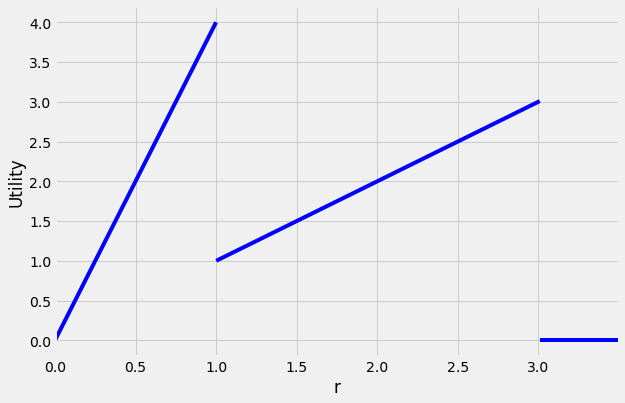

In [2]:
def u(x, r):
    '''
    Utility function
    
    Arguments:
        x: list. True bids.
        r_range: array of possible values for the price.
    '''
    output = np.zeros(len(r))
    for i in range(len(r)): 
        output[i] = r[i] * sum(np.greater_equal(x, r[i]))
    return output

x = [1.00, 1.00, 1.00, 3.01] # Input dataset: the true bids
r = np.arange(0, 3.5, 0.001) # Set the interval of possible outputs r

# Plot the utility (revenue) for each possible output r (price)
utility = u(x, r)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9, 6))
x_intervals = np.sort(np.unique(np.append(x, [r.min(), r.max()])))
for i_interval in range(len(x_intervals) - 1):
    indices_interval = [all(union) for union in zip(
        r > x_intervals[i_interval], r <= x_intervals[i_interval + 1])]
    ax.plot(r[indices_interval], utility[indices_interval], color = "blue")

ax.set_xlim([r.min(), r.max()])
ax.set_xlabel('r')
ax.set_ylabel('Utility')
plt.show()

As explained above, the exponential mechanism is defined with respect the utility function $u : \mathbb N^{|\mathcal{X}|} \times \mathcal{R} \rightarrow \mathbb{R}$, which maps database/output *pairs* to utility scores. For a fixed database $x$, the exponential mechanism outputs each possible $r \in \mathcal{R}$ with probability proportional to $\exp\left(\frac{\epsilon u\left(x, r\right)}{2\Delta u}\right)$. The resulting probability distribution is shown below. <br/>

It can be observed that for low values of $\epsilon$ the probability resembles a flat horizontal curve of the *uniform* probability, thus the privacy increases.
On the contrary, for higher values of $\epsilon$ the probability curve exponentially reveals the jumps in the revenue, implying less privacy. 

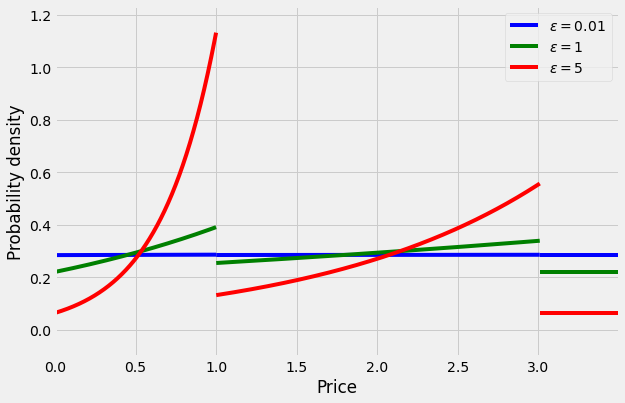

In [3]:
def PDF(x, r, epsilon):
    """
    PDF associated to the database x
    """
    r_min = r.min()
    r_max = r.max()    
    x_intervals = np.sort(np.unique(np.append(x, [r_min, r_max])))
    area = 0
    for i in range(len(x_intervals) - 1):
        S = epsilon/(2*r_max) * sum(np.greater(x, x_intervals[i]))
        if S > 0:
            area_int = 1/S * (np.exp(S * x_intervals[i + 1]) - np.exp(S * x_intervals[i]))
        elif S == 0:
            area_int = x_intervals[i + 1] - x_intervals[i]
        area = area + area_int
    
    u_prob_norm = np.exp(epsilon * u(x, r) / (2 * r_max)) / area
    return u_prob_norm


epsilon_range = [0.01, 1, 5]

fig, ax = plt.subplots(figsize=(9,6))
color_list = ["b", "g", "r", "c", "m"]

r_min = r.min()
r_max = r.max()
x_intervals = np.sort(np.unique(np.append(x, [r_min, r_max])))
for i_epsilon in range(len(epsilon_range)):
    u_prob_norm = PDF(x, r, epsilon_range[i_epsilon])
    for i_interval in range(len(x_intervals) - 1):
        indices_interval = [all(union) for union in zip(
            r > x_intervals[i_interval], r <= x_intervals[i_interval + 1])]
        ax.plot(r[indices_interval], 
                u_prob_norm[indices_interval], 
                color = color_list[i_epsilon], 
                label = '$\epsilon = $' + str(epsilon_range[i_epsilon]))

handles, labels = ax.get_legend_handles_labels()  
handles = handles[0:len(handles):(len(x)-1)]
labels = labels[0:len(labels):(len(x)-1)]
ax.set_xlim([r_min, r_max])
ax.set_ylim([-0.1, max(u_prob_norm) + 0.1])
ax.set_xlabel('Price')
ax.set_ylabel('Probability density')
ax.legend(handles, labels)

plt.show()

We define the appropriate class that implements the exponential mechanism. 

In [4]:
from shfl.private.node import DataNode
from shfl.private.data import DataAccessDefinition

class ExponentialMechanism(DataAccessDefinition):
    """
    Implements the exponential mechanism.
    
    # Arguments:
        u: function with arguments x and r. It should be vectorized, so that for a
        particular database x, it returns as many values as given in r.
        r: array for the response space.
        delta_u: float for the sensitivity of the utility function.
        epsilon: float for the epsilon you want to apply.
        size: integer for the number of queries to perform at once. If not given it defaults to one.
    """
    
    def __init__(self, u, r, delta_u, epsilon, size=1):
        self._u = u
        self._r = r
        self._delta_u = delta_u
        self._epsilon = epsilon
        self._size = size
    
    def apply(self, data):
        r_range = self._r
        u_points = self._u(x, r_range)
        p = np.exp(self._epsilon * u_points / (2 * self._delta_u))      
        p /= p.sum()
        price_sample = np.random.choice(a=r_range, size=self._size, replace=True, p=p)
        return price_sample

We create a node that contains the true bids and choose to access the data using the exponential mechanism. We repeat the experiment 10000 times to check that the resulting distribution for the output price matches the one shown earlier.

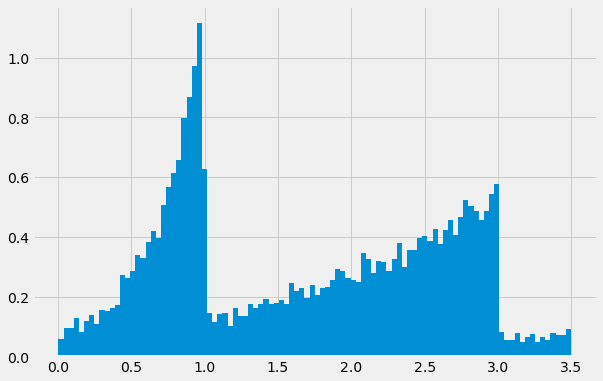

In [5]:
node = DataNode()    # Create a node
node.set_private_data(name="bids", data=np.array(x)) # Store the database x in the node
delta_u = r.max()    # In this specific case, Delta u = max(r)
epsilon = 5          # Set a value for epsilon
size = 10000         # We want to repeat the query this many times

data_access_definition = ExponentialMechanism(u, r, delta_u, epsilon, size)
node.configure_data_access("bids", data_access_definition)
result = node.query("bids")

fig, ax = plt.subplots(figsize=(9,6))
plt.hist(result, bins = int(round(np.sqrt(len(result)))), density = True)
plt.show()

The trade-off between accuracy and privacy can be assessed by computing the mean revenue loss, which is defined as

$${\rm loss}= |u_{OPT}(x) - u(x,r_{sample})|$$ 

where $u_{OPT}(x)$ is the highest possible revenue for a fixed database $x$, and $u(x,r_{sample})$ is the revenue at the sampled price $r_{sample}$.

This is a measure of the loss in utility that we get when using the exponential mechanism compared to the case without privacy at all. The plot below shows that as $\epsilon$ increases (i.e. privacy decreases) the revenue loss goes to zero.

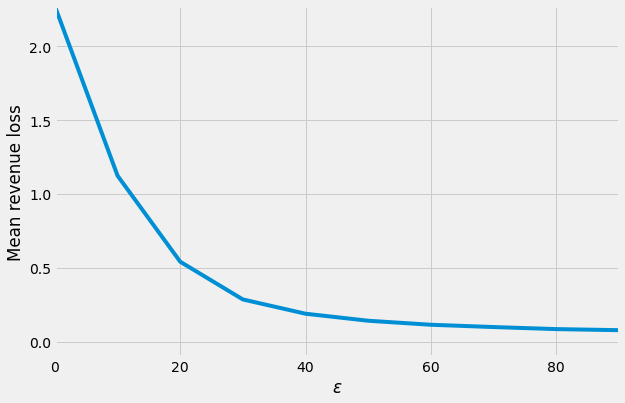

In [6]:
epsilon_range = np.arange(0.001, 100, 10)
optimum_price = float(r[utility == max(utility)])
optimum_revenue = u(x, [optimum_price])
mean_loss = np.zeros(len(epsilon_range))

for i in range(len(epsilon_range)):
    epsilon = epsilon_range[i]
    data_access_definition = ExponentialMechanism(u, r, delta_u, epsilon, size)
    node.configure_data_access("bids", data_access_definition)
    result = node.query("bids")
    mean_loss[i] = np.mean(abs(u(x, result) - optimum_revenue))

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(epsilon_range, mean_loss)
ax.set_xlim([0, max(epsilon_range)])
ax.set_ylim([-0.1, max(mean_loss)])
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Mean revenue loss')

plt.show()

### Example: Randomized response from the exponential mechanism

Consider the case in which $\mathcal R = \{0, 1\}$ and $\mathcal X = \{\text{truly innocent}, \text{truly guilty}\}$ with a utility given by

$$
u(0, 0) = 0\qquad u(1, 0) = 0
$$
$$
u(0, 1) = \beta \qquad u(1, 1) = -\beta
$$

This means that $\Delta u = 2|\beta|$ so $\epsilon = 4\alpha |\beta|$. For concreteness, in the following we choose $\beta = -1/4$ so that $\epsilon = \alpha$.

In the figure below we show the percentage of times the query returns the same value as the true value as a function of $\epsilon$. We observe, that this percentage approaches one as the privacy decreases. For $\epsilon=0$,  which gives maximal privacy, the result of the query it completely uninformative since the probability of getting either result is independent of the true value.

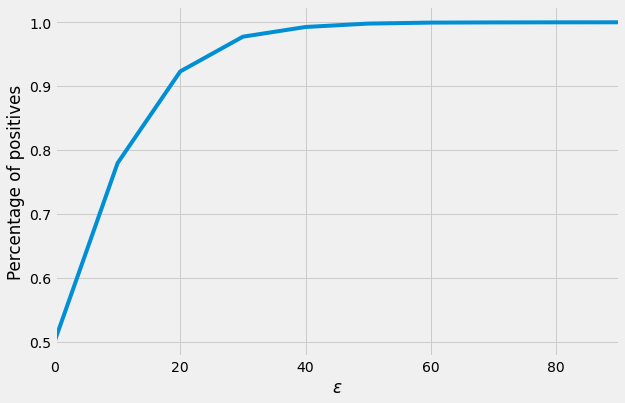

In [7]:
def u_randomized(x, r):
    '''
    Utility function for randomized mechanism
    
    Arguments:
        x: binary number 
        r: array of binaries
    '''
    output = -1/4 * (1 - 2*x) * r
    return output

r = np.array([0,1]) # Set the interval of possible outputs r
x = 1               # Set a value for the dataset
delta_u = 1         # We simply set it to one
size = 100000       # We want to repeat the query this many times

node = DataNode()    # Create a node
node.set_private_data(name="identity", data=np.array(x)) # Store the database x in the node

epsilon_range = np.arange(0.001, 100, 10)
positives = np.zeros(len(epsilon_range))

for i in range(len(epsilon_range)):
    epsilon = epsilon_range[i]
    data_access_definition = ExponentialMechanism(u_randomized, r, delta_u, epsilon, size)
    node.configure_data_access("identity", data_access_definition)
    result = node.query("identity")
    positives[i] = result.sum() / size
    
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(epsilon_range, positives)
ax.set_xlim([0, max(epsilon_range)])
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Percentage of positives')

plt.show()

### Example: Laplace mechanism from the exponential mechanism
We choose the utility function to be $u(x,\,r) = -\left| f(x) - r \right|$ with $r\in\mathbb R$.
Substituting into the exponential mechanism, we obtain an algorithm with conditional probability

$$
P(r|x; f, \alpha) = \frac{\alpha}{2}e^{-\alpha |f(x) - r|}\,.
$$

In this example we pick $f(x)$ to be the identity. We then only need to define the utility function. In the following we show a (normalized) histogram of the result of perfoming the query with laplacian noise repeatedly. As we can see, it gives the exponential distribution centered at the true value $f(x)$.

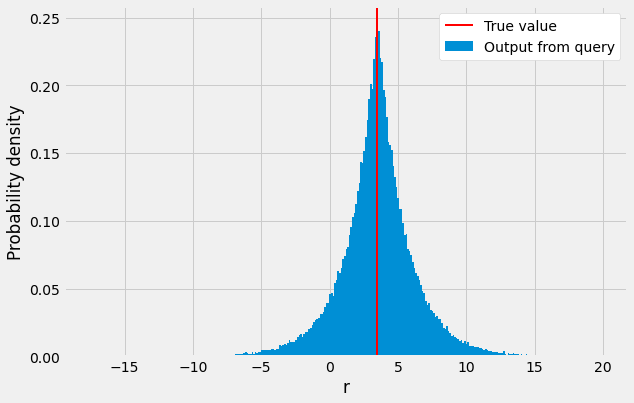

In [8]:
def u_laplacian(x, r):
    '''
    Utility function for Laplacian mechanism
    
    Arguments:
        x: float. 
        r: array of reals.
    '''
    output = -np.absolute(f(x) - r)
    return output

def f(x): 
    '''The identity'''
    return x

# Define some example values:
r_min, r_max = -20, 20        # Set extreme r values
r = np.arange(r_min, r_max, 0.001) # Set the interval of possible outputs r
x = 3.5                       # Set a value for the dataset
delta_u = 1                   # We simply set it to one
epsilon = 1                   # Set a value for epsilon
size = 100000                 # We want to repeat the query this many times

node = DataNode()             # Create a node
node.set_private_data(name="identity", data=np.array(x)) # Store the database x in the node

data_access_definition = ExponentialMechanism(u_laplacian, r, delta_u, epsilon, size)
node.configure_data_access("identity", data_access_definition)
result = node.query("identity")

fig, ax = plt.subplots(figsize=(9,6))
plt.hist(result, bins = int(round(np.sqrt(len(result)))), density = True, label="Output from query")
plt.axvline(x=x, linewidth=2, color='r', label= "True value")
ax.set_xlabel('r')
ax.set_ylabel('Probability density')
ax. legend(facecolor='white', framealpha=1, frameon=True)
plt.show()